# Sentiment classification
The task of classifying sentiments of texts (for example movie or product reviews) has high practical significance in online marketing as well as financial prediction. This is a non-trivial task, since the concept of sentiment is not easily captured.

I will be using the data from the larger IMDB sentiment benchmark dataset from Stanford, an achieve close to state of the art results.

I will use the following models in ascending complexity, namely:

TFIDF + classical statistical model (eg. RandomForest)
LSTM classification model
LSTM model, where the embeddings are initialized with pre-trained GloVe vectors
fastText model
BERT based model (you are advised to use a pre-trained one and finetune, since the resource consumption is considerable!)




# Import data and libraries

In [1]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!ls

--2019-12-21 07:53:28--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  66.8MB/s    in 1.2s    

2019-12-21 07:53:29 (66.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

aclImdb  aclImdb_v1.tar.gz  sample_data


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from glob import glob
import numpy as np
import os,re,string
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
PATH='aclImdb/'
names = ['neg','pos']
!ls {PATH}
!ls {PATH}train
!ls {PATH}train/pos | head

#Similar for the test folder
!ls {PATH}test
!ls {PATH}test/pos | head

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt
0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
0_10.txt
10000_7.txt
10001_9.txt
10002_8.txt
10003_8.txt
10004_9.txt
10005_8.txt
10006_7.txt
10007_10.txt
10008_8.txt


In [0]:
def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    # stored as np.int8 to save space 
    return texts, np.array(labels).astype(np.int8)

train_X,train_y = load_texts_labels_from_folders(f'{PATH}train',names)
val_X,val_y = load_texts_labels_from_folders(f'{PATH}test',names)


In [0]:
# split to valid and testing set
from sklearn.model_selection import train_test_split
val_X, test_X, val_y, test_y = train_test_split(
   val_X, val_y , test_size=0.5, random_state=42)

# EDA

In [0]:
len(train_X),len(train_y),len(val_X),len(val_y), len(test_X), len(test_y)

(25000, 25000, 12500, 12500, 12500, 12500)

We have 25K samples in each train and test sets

In [0]:
uniq_class_arr, counts = np.unique(train_y, return_counts=True)
print ('Unique classes :', uniq_class_arr)
print ('Number of unique classes : ', len(uniq_class_arr))

for _class in uniq_class_arr:
    print ('Counts for class ', uniq_class_arr[_class], ' : ', counts[_class])


Unique classes : [0 1]
Number of unique classes :  2
Counts for class  0  :  12500
Counts for class  1  :  12500


We have 2 classes as we divided them, one for positive 1 and one for negetive 0

In [0]:
# check if the label are as expected 
size_of_samp = 10
rand_samples_to_check = np.random.randint(len(train_X), size=size_of_samp)

for samp_num in rand_samples_to_check:
    print (train_X[samp_num], '||', train_y[samp_num])
    print ('----------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

The world of the Dragon Hunters is a 3D gravity challenged world. Planetoids, bits of buildings and strange flat plants float around in the atmosphere while the ground towards most of the characters are falling is nowhere to be seen. It is a world reminiscent of Neverending Story, when the Nothing came to eat the world away.<br /><br />Funny enough, the villain here is the World Gobbler, as well. This time it is a huge skeleton dragon with fiery eyes. The heroes are a big yet taciturn warrior, an annoying and greedy sidekick managing the entrepreneurial side of the duo and a strange useless animal. They are joined by the most talkative little girl in the world who, to my chagrin, did not die a horrible painful and hopefully early death.<br /><br />The animation is great. The voices and the sounds are top notch. Too bad the story is as simple as one can possibly imagine. They go to stop the World Gobbler, they reach him almost immediately, they defeat him. The end. No real character dev

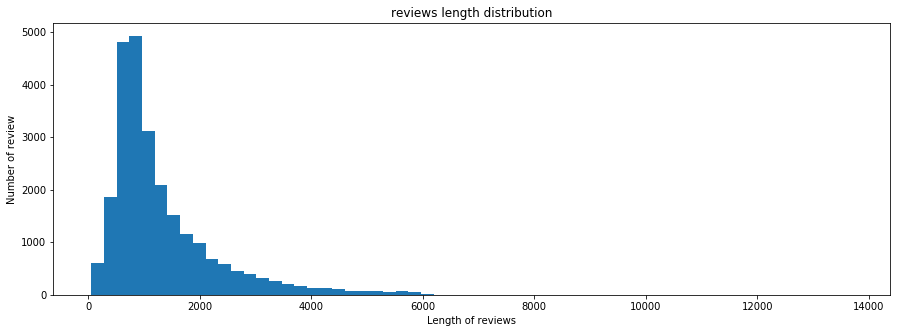

In [0]:
# check the distribution of number of words in each review
plt.figure(figsize=(15, 5))
plt.hist([len(sample) for sample in list(train_X)], 60)
plt.xlabel('Length of reviews')
plt.ylabel('Number of review')
plt.title('reviews length distribution')
plt.show()

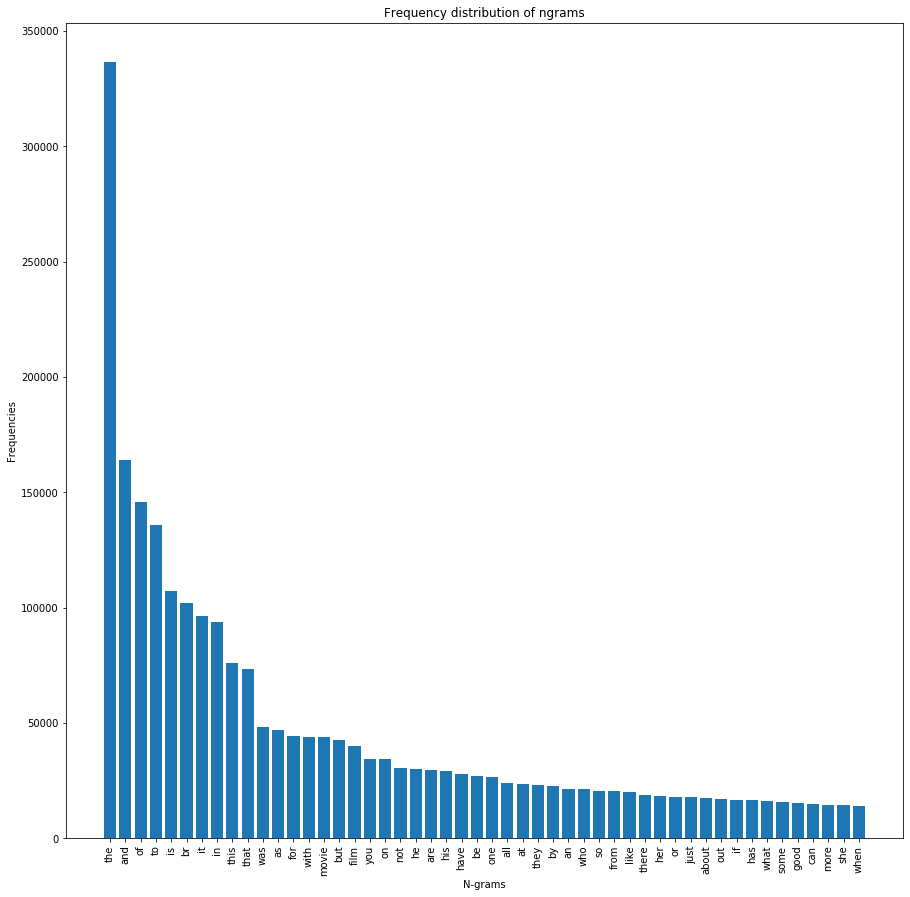

In [0]:
# check the most frequent words
kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(list(train_X))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(15, 15))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=90)
plt.show()


The highest frequency words are the stop words. We will remove this in our anaylsis since it do not provide information to tell the sentiment of the reviews. 

# Text Preprocessing

Text may contain numbers, special characters, and unwanted spaces. I will remove all the special characters, numbers, and unwanted spaces from our text for easier understanding of the text.
I use Regex Expressions from Python re library to perform different preprocessing tasks, like removing all non-word characters such as special characters, numbers, etc.

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove all the special characters
    sentence = re.sub(r'\W', ' ', sentence)
    
    # remove all single characters
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Remove single characters from the start
    sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', sentence) 

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence, flags=re.I)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Converting to Lowercase
    sentence = sentence.lower()

    # Remove stopwords, get stem and lemma of words
    tokenizer = RegexpTokenizer(r'\w+')
    sentence = tokenizer.tokenize(sentence) 
    sentence = [w for w in sentence if not w in stopwords.words('english')]

    # stemmed and lematized the words
    stem_words=[stemmer.stem(w) for w in sentence]
    sentence=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(sentence)
    #return sentence

In [0]:
TAG_RE = re.compile(r'<[^>]+>')
#TAG_RE = re.sub(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [26]:
%%time

# preprocess our reviews and will store them in a new list 
train_X_processed = []
sentences = train_X
for sen in sentences:
    train_X_processed.append(preprocess_text(sen))

CPU times: user 10min 48s, sys: 1min 4s, total: 11min 53s
Wall time: 11min 53s


In [27]:
%%time
val_X_processed = []
sentences = val_X
for sen in sentences:
    val_X_processed.append(preprocess_text(sen))

CPU times: user 5min 17s, sys: 33 s, total: 5min 50s
Wall time: 5min 50s


In [28]:
%%time
test_X_processed = []
sentences = test_X
for sen in sentences:
    test_X_processed.append(preprocess_text(sen))

CPU times: user 5min 18s, sys: 31.2 s, total: 5min 49s
Wall time: 5min 49s


In [29]:
train_X[0]

"This is actually a pretty bad film. The ideology is not as perverse as in those films Collins made later. However, my main misgivings about the film are that it is implausible and quite frankly boring for a long time. The whole concept of an ex-SAS man joining terrorists for no particular reason isn't very convincing and you can't help wondering why a group of highly organized terrorists (who later become pretty clueless) fall for it. The film starts with a pretty powerful scene but then meanders for quite a long time building up towards the great finale. Overall, I think Who dares wins could have been an interesting 45 minutes episode of The Professionals but the story doesn't carry a feature film. Although reasonably successful at the time this film initiated the demise of Collins' career who in the eighties mainly made cheap and dubious soldier-of-fortune or army films. Pity, because he actually is quite a versatile actor but at the end of the day Martin Shaw chose his roles more c

In [30]:
train_X_processed[0]

'actual pretti bad film ideolog pervers film collin made later howev main misgiv film implaus quit frankli bore long time whole concept ex sa man join terrorist particular reason convinc help wonder group highli organ terrorist later becom pretti clueless fall film start pretti power scene meander quit long time build toward great final overal think dare win could interest minut episod profession stori carri featur film although reason success time film initi demis collin career eighti mainli made cheap dubiou soldier fortun armi film piti actual quit versatil actor end day martin shaw chose role care career still success'

# 1. TFIDF + classical statistical model (eg. RandomForest)

## Motivation of the use of TFIDF

TFIDF, short term for frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

TF-IDF(term) = TF(term in a document) * IDF(term)

TF(term) = # of times the term appears in document / total # of terms in document
- it measures how often a term shows up in a single document. If a term appears relatively frequently in a document, it is most likely an important term.

IDF(term) = log(total # of documents / # of documents with term in it)
- it tells us how important a term is to a collection of documents.

The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general, for example the stopwords. TF-IDF returns a vector per word per document based on frequency

### Advantage 
- the process itself is intuitive and its vectors are interpretable. For instance, the TF-IDF of a word can be calculated using a simple formula, and each vector is just a list of word frequencies. 

### Drawbacks
- language is far more complex than the individual words that compose it. Because TF-IDF acts solely on words, it is not as informative nor as powerful as a method like word2vec, which acts on sentences. 

### Converting Text to Numbers: Bag of Words

it is required to convert our text into numbers. Different approaches exist to convert text into the corresponding numerical form. The Bag of Words Model and the Word Embedding Model are two of the most commonly used approaches and here I will use the bag of words model to convert our text to numbers.

Parameters setting:

- max_features: set to 1500. set the max_features parameter to 1500, which means that we want to use 1500 most occurring words as features for training our classifier.

- min_df: set to 5. This corresponds to the minimum number of documents that should contain this feature. So we only include those words that occur in at least 5 documents. 

- stop_words=stopwords.words('english'): in the case of sentiment analysis, stop words may not contain any useful information. 

In [0]:
# Bag of Words: convert text documents into corresponding numerical features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
train_X_bow = vectorizer.fit_transform(train_X_processed).toarray()

In [0]:
val_X_bow = vectorizer.fit_transform(val_X_processed).toarray()

### Finding TFIDF

Since the bag of words only count the occurence of the words, however, those words might be having high frequency of occurence in other docments as well. TFIDF resolve this issues by multiplting the term frequency of word by the inverse document frequency. 

The TFIDF value for a word in a particular document is higher if the frequency of occurrence of that word is higher in that specific document but lower in all the other documents.

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
train_X_tfidf = tfidfconverter.fit_transform(train_X_bow).toarray()

In [0]:
val_X_tfidf = tfidfconverter.fit_transform(val_X_bow).toarray()

In [84]:
val_X_tfidf[1]

array([0., 0., 0., ..., 0., 0., 0.])

### Training Random Forest Classification Model
Random Forest, which is composed by combining multiple decision trees. While  dealing  with  the  single  tree  classifier  there  may  be  the problem of noise or outliers which may possibly affect the result of the overall classification method, whereas Random Forest is a  type  of  classifier  which  is  very  much  robust  to  noise  and outliers because of randomness it provides.

Advantage of Random Forest Classifier
- Robust: As   Random   Forest   uses   the   concept   of Bootstrapping, so each tree works on the  subset of the total training data, and due to that each tree is trained on the  different  value  of  training  data.  So  that  it  is  very much robust in terms of noise. 
- Accurate: Random  Forest  make  use  of  concept  of Bagging so that output of all decision classifier will be averaged,  as  there  is  a  logical  proof  that  when  infinite number of data is provided to a single classifier then the result  will  not  be  consistent,  whereas  if  those  data  is divided into number of classifier, then averaging of the result of those classifier will be consistent.

Disadvantage
- require long time to do hyperparameter tuning 


In [85]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, random_state=0 )
rf.fit(train_X_tfidf, train_y) 

CPU times: user 3min 15s, sys: 109 ms, total: 3min 15s
Wall time: 3min 15s


In [0]:
y_pred = rf.predict(val_X_tfidf)

### Evaluating the Model

To evaluate the performance of a classification model, I will use confusion matrix, F1 measure, and accuracy. 

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(val_y,y_pred))
print(classification_report(val_y,y_pred))
print(accuracy_score(val_y, y_pred))

[[2290 3902]
 [1280 5028]]
              precision    recall  f1-score   support

           0       0.64      0.37      0.47      6192
           1       0.56      0.80      0.66      6308

    accuracy                           0.59     12500
   macro avg       0.60      0.58      0.56     12500
weighted avg       0.60      0.59      0.57     12500

0.58544


Our model achieved an accuracy of 58.5% with randomly chose paramter. 

### Try to improve accuracy by Hyperparameter tuning for Random Forest Classifier

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(300, 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 200, num = 10)]
# Maximum number of features 
max_features = sp_randint(1, 11)
# Minimum number of samples required to split a node
min_samples_split = sp_randint(2, 11)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion =  ["gini", "entropy"]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)

{'n_estimators': [300, 377, 455, 533, 611, 688, 766, 844, 922, 1000], 'max_depth': [5, 26, 48, 70, 91, 113, 135, 156, 178, 200], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff449b92710>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff449b92320>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [0]:
import time
start_time = time.time()
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = 1)
rf_random.fit(train_X_tfidf, train_y) 
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] bootstrap=True, criterion=entropy, max_depth=113, max_features=1, min_samples_split=5, n_estimators=533 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=entropy, max_depth=113, max_features=1, min_samples_split=5, n_estimators=533, total=  21.2s
[CV] bootstrap=True, criterion=entropy, max_depth=113, max_features=1, min_samples_split=5, n_estimators=533 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=113, max_features=1, min_samples_split=5, n_estimators=533, total=  21.1s
[CV] bootstrap=True, criterion=entropy, max_depth=113, max_features=1, min_samples_split=5, n_estimators=533 
[CV]  bootstrap=True, criterion=entropy, max_depth=113, max_features=1, min_samples_split=5, n_estimators=533, total=  21.2s
[CV] bootstrap=False, criterion=entropy, max_depth=70, max_features=6, min_samples_split=4, n_estimators=611 
[CV]  bootstrap=False, criterion=entropy, max_depth=70, max_features=6, min_samples_split=4, n_estimators=611, total= 1.1min
[CV] bootstrap=False, criterion=entropy, max_depth=70, max_features=6, min_samples_split=4, n_estimators=611 
[CV]  bootstrap=False, criterion=entropy, max_depth=70, max_features=6, min_samples_split=4, n_estimators=611, total= 1.1min
[CV] bootstrap=False, criterion=entropy, max_depth=70, max_features=6, min_samples_split=4, n_estimators=611 
[CV]  bootstrap=False, criterion=entropy, max_depth=70, max_

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 29.1min finished


--- 1931.1191902160645 seconds ---


In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = rf_random.predict(val_X_tfidf)
print(confusion_matrix(val_y,y_pred))
print(classification_report(val_y,y_pred))
print(accuracy_score(val_y, y_pred))

[[6673 5827]
 [4195 8305]]
              precision    recall  f1-score   support

           0       0.61      0.53      0.57     12500
           1       0.59      0.66      0.62     12500

    accuracy                           0.60     25000
   macro avg       0.60      0.60      0.60     25000
weighted avg       0.60      0.60      0.60     25000

0.59912


Random forest classifier had achieved 60% accuracy. 

### Why random forest classifer didn't perform well?
Previous research shows that Random Forest classifier can reach 87% in sentiment analysis, however,  tuning  of hyperparameters  in  random  forest  needs  a  special  attention because they are required to be tuned manually so it is very time consuming and complex. To reach a better accuracy, it will require more time for hyperparameter tuning. 


# 2. LSTM classification model


Advantage of using LSTM as sentiment analysis
- The main advantage of this network is that it is able to remember the sequence of past data i.e. words in our case in order to make a decision on the sentiment of the word.
Hopefully, we deep learning model, the accuracy level will be improved!

### Preparing the Embedding Layer

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [0]:
tokenizer = Tokenizer(num_words=5000)
# cut texts after this number of words (among top max_features most common words)

tokenizer.fit_on_texts(train_X_processed)

X_train = tokenizer.texts_to_sequences(train_X_processed)
X_val = tokenizer.texts_to_sequences(val_X_processed)
X_test = tokenizer.texts_to_sequences(test_X_processed)

In [56]:
print("X_train : ",X_val[0],'\n')

print("word_index : ",tokenizer.word_index)

X_train :  [3825, 1115, 32, 4, 23, 4214, 211, 42, 2600, 8, 906, 1461, 775, 988, 3564, 274, 326, 928, 540, 991, 111, 293, 1034, 23, 2251, 1, 953, 17, 871, 1367, 2726, 13, 17, 190, 4353, 2019, 272, 2403, 562, 17, 265, 791, 24, 123, 4556, 436, 17, 912, 1000, 171, 1166, 2367, 241, 4975, 4717, 435, 11, 1, 128, 20, 1380, 165, 2600, 1, 105, 724, 517, 1409, 2274, 2600, 1067, 2600, 2526, 211, 150, 1377, 355, 402] 

word_index :  {'movi': 1, 'film': 2, 'one': 3, 'like': 4, 'time': 5, 'good': 6, 'make': 7, 'charact': 8, 'get': 9, 'see': 10, 'watch': 11, 'stori': 12, 'even': 13, 'would': 14, 'realli': 15, 'well': 16, 'scene': 17, 'look': 18, 'show': 19, 'much': 20, 'end': 21, 'peopl': 22, 'bad': 23, 'go': 24, 'great': 25, 'also': 26, 'first': 27, 'love': 28, 'think': 29, 'way': 30, 'act': 31, 'play': 32, 'made': 33, 'thing': 34, 'could': 35, 'know': 36, 'say': 37, 'seem': 38, 'work': 39, 'plot': 40, 'two': 41, 'year': 42, 'actor': 43, 'come': 44, 'mani': 45, 'seen': 46, 'take': 47, 'want': 48, 'li

In [0]:
from keras.preprocessing import sequence
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# set the maximum size of each list to 100
maxlen = 100

X_train_ = sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val_ = sequence.pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test_ = sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

### Create and train LSTM model

In [0]:
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          6453248   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 6,584,961
Trainable params: 6,584,961
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
%%time
#history = model.fit(X_train_, train_y, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
history = model.fit(X_train_, train_y, batch_size=128, epochs=10, verbose=1, validation_data=(X_val_, val_y))
score = model.evaluate(X_val_, val_y, verbose=1)

Train on 25000 samples, validate on 12500 samples
Epoch 1/10
25000/25000 [==============================] - 42s 2ms/sample - loss: 0.5370 - acc: 0.7235 - val_loss: 0.4283 - val_acc: 0.8366
Epoch 2/10
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.3793 - acc: 0.8606 - val_loss: 0.4709 - val_acc: 0.8326
Epoch 3/10
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.3703 - acc: 0.8667 - val_loss: 0.4021 - val_acc: 0.8462
Epoch 4/10
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.3372 - acc: 0.8785 - val_loss: 0.4039 - val_acc: 0.8455
Epoch 5/10
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.3021 - acc: 0.8907 - val_loss: 0.3578 - val_acc: 0.8540
Epoch 6/10
25000/25000 [==============================] - 42s 2ms/sample - loss: 0.2744 - acc: 0.9017 - val_loss: 0.3772 - val_acc: 0.8547
Epoch 7/10
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.2568 - acc: 0.9058 - val_loss: 0.

In the output, the validation accuracy is around 84%. The validation accuracy is better than random forest classifier. There are difference in te training accuray and validation accuray, so it means there is still overfitting problem. 

In [40]:
print("Validation loss:", score[0])
print("Validation Accuracy:", score[1])

Validation loss: 0.40995107192993163
Validation Accuracy: 0.84912


Validation accuracy has reached 85%.













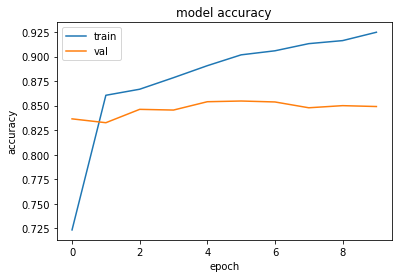

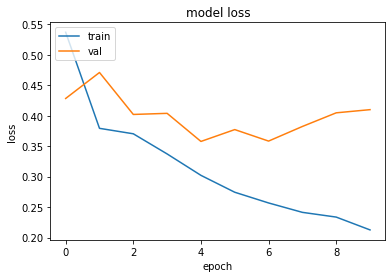

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

### Making Predictions on Single Instance

In [42]:
instance = train_X_processed[0]
print(instance)

actual pretti bad film ideolog pervers film collin made later howev main misgiv film implaus quit frankli bore long time whole concept ex sa man join terrorist particular reason convinc help wonder group highli organ terrorist later becom pretti clueless fall film start pretti power scene meander quit long time build toward great final overal think dare win could interest minut episod profession stori carri featur film although reason success time film initi demis collin career eighti mainli made cheap dubiou soldier fortun armi film piti actual quit versatil actor end day martin shaw chose role care career still success


In [43]:
print(train_y[0])

0


In [44]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.01083132]], dtype=float32)

The sigmoid function predicts floating value between 0 and 1. If the value is less than 0.5, the sentiment is considered negative where as if the value is greater than 0.5, the sentiment is considered as positive. The sentiment value for the single instance is 0.01 which means that the sentiment is predicted as negative, which actually is the case.

### Test on testing dataset

In [58]:
score = model.evaluate(X_test_, test_y, verbose=1)

12500/12500 [==============================] - 16s 1ms/sample - loss: 0.3915 - acc: 0.8517


In [59]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3914588785648346
Test Accuracy: 0.85168


We have acheived 85% in the testing dataset. I will next try to experiment with learning a word embedding using a pre-trained embedding with GloVe and check if this could improve the result. 


# 3. LSTM model, where the embeddings are initialized with pre-trained GloVe vectors


I will use word embedding from pre-trained GloVe to create feature matrix. It was trained on a dataset of one billion tokens with a vocabulary of 400 thousand words. 

Why use GloVe embedding?
- GloVe builds word embeddings in a way that a combination of word vectors relates directly to the probability of these words’ co-occurrence in the corpus
- GloVe focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.


In [66]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
#!tar -xzf glove.6B.zip

--2019-12-21 09:39:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-21 09:39:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-21 09:39:55--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [68]:
!unzip glove*.zip.2
!ls
!pwd

Archive:  glove.6B.zip.2
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
aclImdb		   glove.6B.200d.txt  glove.6B.zip    sample_data
aclImdb_v1.tar.gz  glove.6B.300d.txt  glove.6B.zip.1
glove.6B.100d.txt  glove.6B.50d.txt   glove.6B.zip.2
/content


### GloVe embedding

The glove has embedding vector sizes: 50, 100, 200 and 300 dimensions. I chose the 100-dimensional one. 

In [69]:
# Extract word embeddings from the Glove
print('Indexing word vectors.')

embeddings_dictionary = {}
glove_file  = open('glove.6B.100d.txt', encoding='utf-8')
for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
glove_file .close()

print('Found %s word vectors.' % len(embeddings_dictionary))

Indexing word vectors.
Found 400000 word vectors.


Create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.

In [0]:
# Create a weight matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [71]:
len(embedding_matrix )

50416

### Create LSTM model with pre-trained GloVe vectors

I start by initializing a sequential model followed by the creation of the embedding layer. Next, we create an LSTM layer with 128 neurons.  I keep the “trainable” parameter as ‘False’ to see if the model imporves while keeping the word embeddings fixed.

In [0]:
# create the model
from keras import backend as K
K.clear_session()

model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))
                         
model_glove.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_glove.add(Dense(1, activation='sigmoid'))

In [73]:
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model_glove.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          5041600   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 5,083,905
Trainable params: 5,083,905
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
%%time
# train the model on the training set and evaluate its performance on the validation set
history = model_glove.fit(X_train_, train_y, batch_size=64, epochs=10, verbose=1,  validation_data=(X_val_, val_y))

score = model_glove.evaluate(X_val_, val_y, verbose=1)

Train on 25000 samples, validate on 12500 samples
Epoch 1/10
25000/25000 [==============================] - 85s 3ms/sample - loss: 0.5899 - acc: 0.6860 - val_loss: 0.5113 - val_acc: 0.7716
Epoch 2/10
25000/25000 [==============================] - 84s 3ms/sample - loss: 0.5248 - acc: 0.7694 - val_loss: 0.4444 - val_acc: 0.8174
Epoch 3/10
25000/25000 [==============================] - 85s 3ms/sample - loss: 0.4382 - acc: 0.8205 - val_loss: 0.3917 - val_acc: 0.8403
Epoch 4/10
25000/25000 [==============================] - 85s 3ms/sample - loss: 0.4009 - acc: 0.8331 - val_loss: 0.4109 - val_acc: 0.8482
Epoch 5/10
25000/25000 [==============================] - 85s 3ms/sample - loss: 0.4265 - acc: 0.8127 - val_loss: 0.5712 - val_acc: 0.7637
Epoch 6/10
25000/25000 [==============================] - 85s 3ms/sample - loss: 0.4663 - acc: 0.8097 - val_loss: 0.4181 - val_acc: 0.8379
Epoch 7/10
25000/25000 [==============================] - 85s 3ms/sample - loss: 0.3689 - acc: 0.8602 - val_loss: 0.

In [77]:
print("Validation Loss:", score[0])
print("Validation Accuracy:", score[1])

Validation Loss: 0.36679696932792666
Validation Accuracy: 0.8576


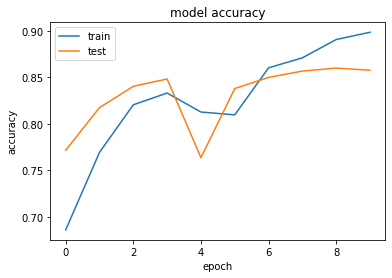

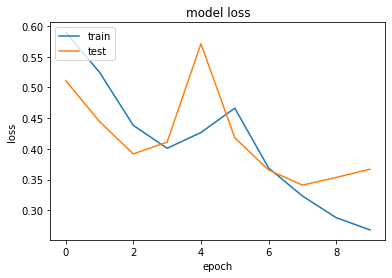

In [78]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Why GloVe embedding have a better result than the prvious LSTM model?
- With GloVe embedding, the training loss decays more quickly and faster training than the embedding-layer-based model. It can be interpreted that the model could pick up more semantic signals from the pre-trained embeddings than it did from the training data through the embedding layer.

### Test on testing dataset

In [79]:
score = model_glove.evaluate(X_test_, test_y, verbose=1)

12500/12500 [==============================] - 16s 1ms/sample - loss: 0.3440 - acc: 0.8635


In [80]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.34399152638435365
Test Accuracy: 0.86352


I have acheived 86% in the testing dataset. It performed better than the previous models.
 
Drawback of GloVe embedding: 
- it cannot be generalise to unknow words. 

FastText developed by Facebook had promised to overcome this obstacle. I will next try to experiment with fastText model.

# 4. fastText model

fastText embeddings consists of part of words and characters.

Advantage: 
- generalization is possible as long as new words have the same characters as known ones. 
- less training data is needed since much more information can be extracted from each piece of text. 

In [0]:
#!pip3 install ktrain

### Loading / preprocessing

In [125]:
import ktrain
from ktrain import text
(x_train,  y_train), (x_val, y_val), preproc = text.texts_from_array(x_train=train_X_processed, y_train=train_y,
                                                                       x_test=val_X_processed, y_test=val_y,
                                                                       max_features=20000, 
                                                                      maxlen=400,
                                                                       class_names=[0,1],
                                                                      ngram_range=1) 
                                                                     

language: en
Word Counts: 50415
Nrows: 25000
25000 train sequences
Average train sequence length: 117
x_train shape: (25000,400)
y_train shape: (25000,2)
12500 test sequences
Average test sequence length: 112
x_test shape: (12500,400)
y_test shape: (12500,2)


### Loading fastText model

In [126]:
model_fasttext = text.text_classifier('fasttext', (x_train, y_train), 
                             preproc=preproc)
learner_fasttext = ktrain.get_learner(model_fasttext, train_data=(x_train, y_train), val_data=(x_val, y_val))

Is Multi-Label? False
compiling word ID features...
maxlen is 400
done.


simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
25000/25000 [==============================] - 8s 319us/sample - loss: 1.0315 - acc: 0.5040
Epoch 2/1024
25000/25000 [==============================] - 7s 284us/sample - loss: 0.7010 - acc: 0.5977
Epoch 3/1024
 6176/25000 [======>.......................] - ETA: 5s - loss: 16.0702 - acc: 0.4955

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.
CPU times: user 33.9 s, sys: 3.04 s, total: 36.9 s
Wall time: 28.8 s


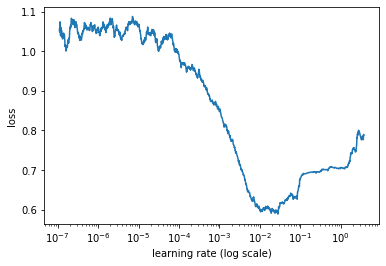

In [127]:
%%time
learner_fasttext.lr_find()
learner_fasttext.lr_plot()

### Training 

In [128]:
%%time
learner_fasttext.autofit(0.005, 2)



begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 12500 samples
Epoch 1/2
25000/25000 [==============================] - 15s 595us/sample - loss: 0.5929 - acc: 0.6999 - val_loss: 0.3837 - val_acc: 0.8383
Epoch 2/2
25000/25000 [==============================] - 11s 426us/sample - loss: 0.4122 - acc: 0.8164 - val_loss: 0.3459 - val_acc: 0.8537
CPU times: user 31.2 s, sys: 3.43 s, total: 34.6 s
Wall time: 25.6 s


In [129]:
print("Validation Loss:", score[0])
print("Validation Accuracy:", score[1])

Validation Loss: 0.34399152638435365
Validation Accuracy: 0.86352


### Test on testing dataset

In [0]:
learner_fasttext = ktrain.get_predictor(learner_fasttext.model, preproc)

In [0]:
pred_y =learner_fasttext.predict(test_X_processed)
pred_y = list(map(int, pred_y))
pred_y=np.asarray(pred_y)

In [132]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_y,pred_y))
print(classification_report(test_y,pred_y))
print(accuracy_score(test_y, pred_y))

[[5269 1039]
 [ 726 5466]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      6308
           1       0.84      0.88      0.86      6192

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500

0.8588


I have acheived 86% in the testing dataset. Advantage of fastText would be it runs really quick to train the model, however, fastText does not use pre-trained word embeddings, which can be explained why it has a lower accuracy . I will next try to experiemnt to  train on pre-trained word BERT embedding.

### "Explaining" model performance

In [0]:
data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
         'The film really sucked. I want my money back.',
        'The plot had too many holes.',
        'What a beautiful romantic comedy. 10/10 would see again!',
         ]

In [101]:
learner_fasttext.predict(data)


[0, 1, 1, 1]

# 5. BERT based model 

BERT (Bidirectional Encoder Representations from Transformers) is a deep learning model developed by Google.Since it is Bidirectional, it is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text.

### Loading / preprocessing

In [115]:
import ktrain
from ktrain import text
(x_train_bert, y_train_bert), (x_val_bert, y_val_bert), preproc_bert = text.texts_from_array(x_train=train_X, y_train=train_y,
                                                                       x_test=val_X, y_test=val_y,
                                                                      #max_features=1000, 
                                                                      maxlen=200,
                                                                      preprocess_mode='bert')

preprocessing train...
language: en


preprocessing test...
language: en


### Loading the (pretrained) model

In [116]:
# load model
model_bert = text.text_classifier('bert', (x_train_bert, y_train_bert), preproc=preproc_bert)
 


Is Multi-Label? False
maxlen is 200
done.


get_learner uses the ktraintext_classifier function to load the pretrained BERT model with a randomly initialized final Dense layer. The second and third arguments are the training and validation data, respectively. The last argument to get_learner is the batch size. We use a small batch size of 6 based on the following recommendations from Google for 12GB GPUs

In [0]:
# wrap model and data in ktrain.Learner object

learner_bert = ktrain.get_learner(model_bert, 
                             train_data=(x_train_bert, y_train_bert), 
                            # val_data=(x_val_bert, y_val_bert),  # since it takes so long for BERT to train, i will take out the val_data here 
                             batch_size=6)

### Using "learning rate finder" functionality to search for optimal training parameters

simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
 6678/25000 [=======>......................] - ETA: 23:37 - loss: 0.6526 - acc: 0.6361

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.
CPU times: user 4min 59s, sys: 2min 26s, total: 7min 25s
Wall time: 8min 57s


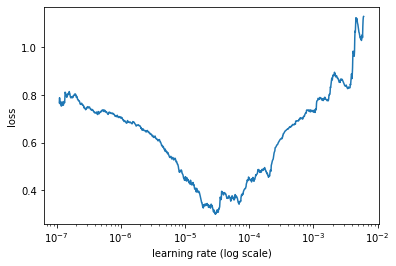

In [105]:
%%time
learner_bert.lr_find()             # briefly simulate training to find good learning rate
learner_bert.lr_plot()             # visually identify best learning rate

### Training 

Maximum learning rate of 2e-5 is used based on recommendations from the paper.  

In [118]:
%%time
# using 1cycle learning rate schedule for 3 epochs
learner_bert.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 780s 31ms/sample - loss: 0.3092 - acc: 0.8672
Epoch 2/3
25000/25000 [==============================] - 771s 31ms/sample - loss: 0.2001 - acc: 0.9231
Epoch 3/3
25000/25000 [==============================] - 771s 31ms/sample - loss: 0.0684 - acc: 0.9772
CPU times: user 31min 29s, sys: 10min 35s, total: 42min 5s
Wall time: 39min


With 3 epoch, I have reached 97% accuracy on training set. The performance of BERT is very impressive, however it takes so much time to run.

In [120]:
%%time
learner_bert.validate(val_data=(x_val_bert, y_val_bert))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      6192
           1       0.91      0.92      0.91      6308

    accuracy                           0.91     12500
   macro avg       0.91      0.91      0.91     12500
weighted avg       0.91      0.91      0.91     12500

CPU times: user 17.2 s, sys: 6.15 s, total: 23.4 s
Wall time: 1min 32s


array([[5611,  581],
       [ 520, 5788]])

Achieved 91% for the validation set. 

### Test on testing dataset

Call the learner.get_predictor method to obtain a Predictor object capable of making predictions on new raw data.

In [0]:
predictor_bert = ktrain.get_predictor(learner_bert.model, preproc_bert)

In [123]:
pred_y =predictor_bert.predict(test_X)
pred_y = list(map(int, pred_y))
pred_y=np.asarray(pred_y)

In [124]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_y,pred_y))
print(classification_report(test_y,pred_y))
print(accuracy_score(test_y, pred_y))

[[5736  572]
 [ 449 5743]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6308
           1       0.91      0.93      0.92      6192

    accuracy                           0.92     12500
   macro avg       0.92      0.92      0.92     12500
weighted avg       0.92      0.92      0.92     12500

0.91832



BERT acheived 91% for unseen data which is very impressive. 

Drawback on BERT: 
- While BERT’s performance is impressive, it is comparatively slow in terms of both training and inference (i.e., predictions on new data).
